<a href="https://colab.research.google.com/github/MertYuksek/predict-sequences-with-rnn/blob/main/RNN_Predict_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Create temporal sequence data

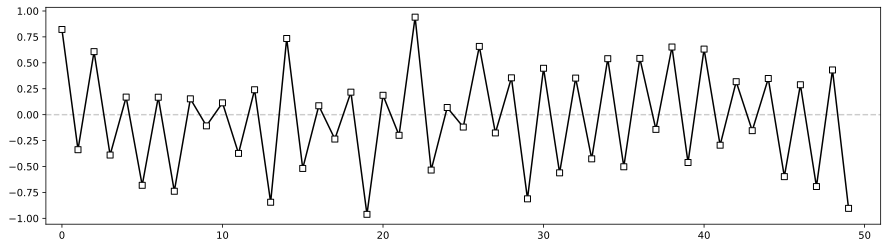

torch.Size([50])


In [165]:
# This is one data stream, one feature, one data channel,
# one measuremnet. So our input size = 1 !!!!!!!!!!!!!!!!!

# import the data
N = 50
data = torch.zeros(N)

#print(data.shape) # 50x1

for i in range(N):
  data[i] = torch.rand(1) * (-1)**i # our values - + - + ...

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()
print(data.shape)

# Create a class for the DL model

In [166]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self,x):
    
    # print(f'Input: {list(x.shape)}')

    # run through the RNN layer
    y,hidden = self.rnn(x) # we don't need to specify hidden states, it default zero.
    # print(f'RNN-out: {list(y.shape)}')
    # print(f'RNN-hidden: {list(hidden.shape)}')
    
    # pass the RNN output through the linear output layer
    x = self.out(y)
    # print(f'Output: {list(x.shape)}')

    return x,hidden

In [167]:
# network parameters
input_size = 1 # one data channel
num_hidden = 5 # number of units in hidden layers
num_layers = 1 # depth of model number of stacks of hidden layers
seqlength = 9  # number of data point used for learning in each segment
batchsize = 1

# create an instance of model
#net = rnnnet(input_size, num_hidden, num_layers)

#X = torch.rand(seqlength, batchsize, input_size) 
#y, h = net(X)
#print(f'Input shape: {list(X.shape)}') # 9x1x1
#print(f'Hidden shape: {list(h.shape)}') # 1x1x5
# Note: this is one output per sequence element; generally we take the final output.
#print(f'Output shape: {list(y.shape)}') # 9x1x1 it is not RNN-out (9x1x5).

# Train the model and show performance

In [168]:
numepochs = 50

# create a new instance of the model and optimizer
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)
lossfun = nn.MSELoss()

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc = []
  hidden_state = torch.zeros(num_layers, batchsize, num_hidden) # reset the hidden states not weights !!!!

  for timei in range(N - seqlength): # 41
    
    # grap a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)  
    y = data[timei+seqlength].view(1, 1)                  
    # print(X.shape)
    # print(y.shape)

    # forward pass and loss
    yhat,hidden_state = net(X)
    finalValue = yhat[-1]
    loss = lossfun(finalValue, y) # compare final value of output with real value

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

    # sign accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*np.mean(truesign==predsign)
    segacc.append(accuracy)
    # print(f'True sign : {truesign}, Predicted sign : {predsign}')

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)
  signaccuracy[epochi] = np.mean(segacc)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 50/50

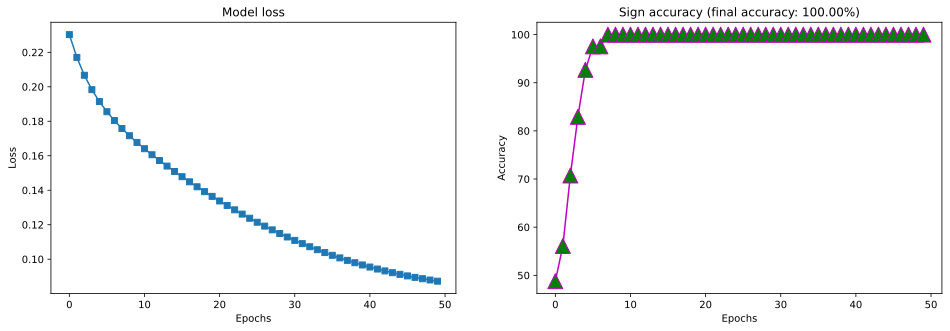

In [169]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signaccuracy,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signaccuracy[-1])

plt.show()

# Test model

(50, 5)


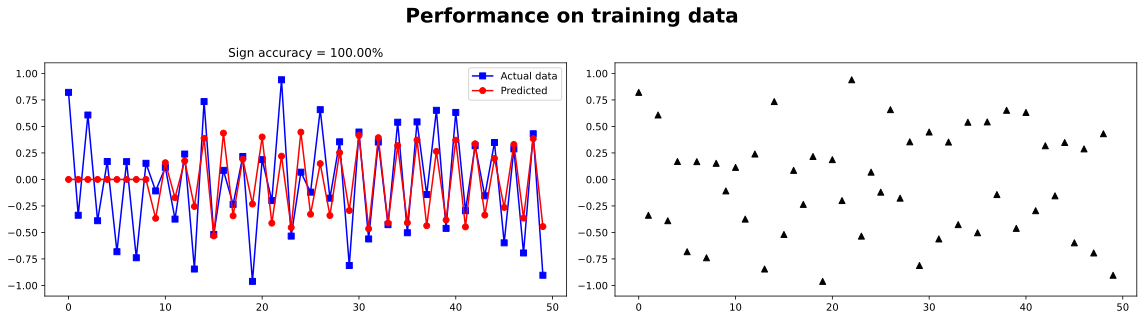

In [170]:
# initalize hidden state
h = np.zeros((N,num_hidden))
print(h.shape)

# initialize predicted values
yHat_predict = np.zeros(N)

segacc = []

# loop over time segments
for timei in range(N - seqlength): # 41
    
    # grap a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)  
    y = data[timei+seqlength].view(1, 1) 

    # forward pass and loss
    yhat,hidden_state = net(X)
    # print(hidden_state.shape)
    finalValue = yhat[-1] 
    yHat_predict[timei+seqlength]= finalValue


    # compute sign-accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*np.mean(truesign==predsign) 
    segacc.append(accuracy)

signaccuracy = np.mean(segacc)

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat_predict,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


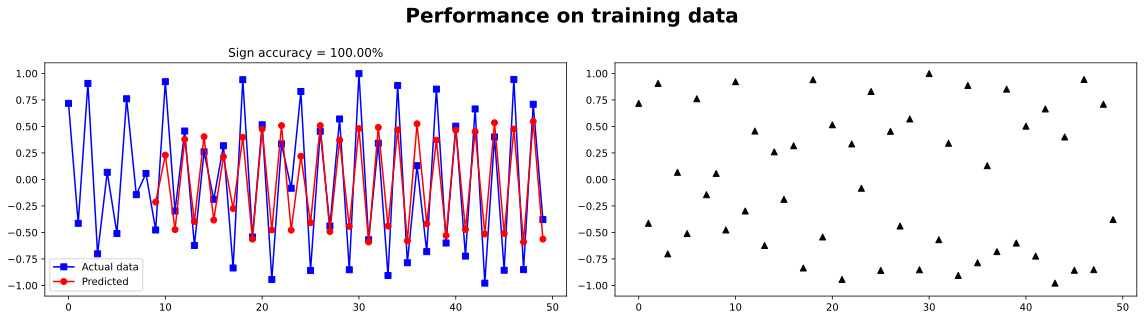

In [171]:
# Create new data
newdata = torch.zeros(N)
for i in range(N):
  newdata[i] = torch.rand(1) * (-1)**(i+1000)

# initialize predicted values
yHat_predict = np.zeros(N)/0

segacc = []

# loop over time segments
for timei in range(N - seqlength): # 41
    
    # grap a snippet of data
    X = newdata[timei:timei+seqlength].view(seqlength, 1, 1)  
    y = newdata[timei+seqlength].view(1, 1) 

    # forward pass and loss
    yhat,hidden_state = net(X)
    # print(hidden_state.shape)
    finalValue = yhat[-1] 
    yHat_predict[timei+seqlength]= finalValue


    # compute sign-accuracy
    truesign = np.sign(torch.squeeze(y).numpy())
    predsign = np.sign(torch.squeeze(finalValue).detach().numpy())
    accuracy = 100*np.mean(truesign==predsign) 
    segacc.append(accuracy)

signaccuracy = np.mean(segacc)

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat_predict,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signaccuracy)
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

In [175]:
net.rnn.weight_hh_l0

Parameter containing:
tensor([[ 0.3740,  0.2982,  0.1421, -0.2301, -0.0869],
        [ 0.3446, -0.4596,  0.3737,  0.3484, -0.2991],
        [-0.3405,  0.0761, -0.0171, -0.2927,  0.4348],
        [ 0.3741, -0.1065,  0.0047, -0.2905, -0.0090],
        [ 0.1025,  0.3097, -0.1309, -0.1863,  0.3312]], requires_grad=True)

In [176]:
net.rnn.weight_ih_l0

Parameter containing:
tensor([[ 0.0491],
        [ 0.6193],
        [-0.1942],
        [-0.4004],
        [-0.4045]], requires_grad=True)